In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
df =  pd.read_csv('nearest-earth-objects(1910-2024).csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [ ]:
df = df.drop('neo_id', axis=1)

# 1. Cleaning Dataset

Checking missing values

In [ ]:
df.isnull().sum()

,0
name,0
absolute_magnitude,28
estimated_diameter_min,28
estimated_diameter_max,28
orbiting_body,0
relative_velocity,0
miss_distance,0
is_hazardous,0


Check if these missing values in the same period

In [ ]:
len(df[(df['absolute_magnitude'].isnull() == True) & (df['estimated_diameter_min'].isnull() == True) & (df['estimated_diameter_max'].isnull() == True) ])

28

In [ ]:
# Rows where all specified columns have missing values
missing_rows = df[df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max']].isna().all(axis=1)]
missing_rows

,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
107508,(2010 DJ77),NaN,NaN,NaN,Earth,69599.619497,4.163668e+07,False
111671,(2010 DJ77),NaN,NaN,NaN,Earth,48866.251824,5.876855e+07,False
114171,(2010 DJ77),NaN,NaN,NaN,Earth,50912.941751,7.713979e+06,False
116688,(2010 DJ77),NaN,NaN,NaN,Earth,80266.699067,6.088422e+07,False
146059,(2010 DJ77),NaN,NaN,NaN,Earth,70193.252023,4.273236e+07,False
148836,(2010 DJ77),NaN,NaN,NaN,Earth,49737.645508,2.537158e+07,False
150446,(2010 DJ77),NaN,NaN,NaN,Earth,49134.581521,5.965592e+07,False
153108,(2010 DJ77),NaN,NaN,NaN,Earth,50646.135198,7.584209e+06,False
155973,(2010 DJ77),NaN,NaN,NaN,Earth,79709.497213,5.997446e+07,False
186857,(2010 DJ77),NaN,NaN,NaN,Earth,71005.133933,4.413829e+07,False


As the missing values has the same name and the same orbiting body "Earth" and classified as False but the have different relative_velocity and miss_distance  

Calculate the correlation coefficients between relative_velocity, miss_distance, and the missing features.

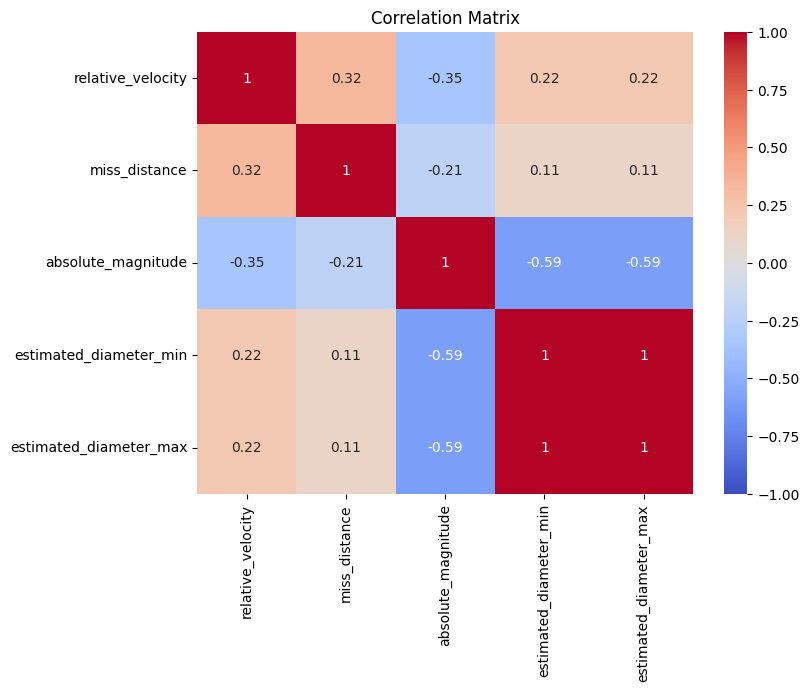

In [ ]:
# Calculate correlation matrix
correlation_matrix = df[['relative_velocity', 'miss_distance', 'absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Charts indicate that relative_velocity and miss_distance are not good predictors for imputation the missing values. Since the missing values have the same name and orbiting_body the it is better to Group by 'name' and 'orbiting_body' and impute missing values with the group median

In [ ]:
df['absolute_magnitude'] = df.groupby(['name'])['absolute_magnitude'].transform(lambda x: x.fillna(x.median()))
df['estimated_diameter_min'] = df.groupby(['name'])['estimated_diameter_min'].transform(lambda x: x.fillna(x.median()))
df['estimated_diameter_max'] = df.groupby(['name'])['estimated_diameter_max'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Impute remaining missing values with global median
df['absolute_magnitude'].fillna(df['absolute_magnitude'].median(), inplace=True)
df['estimated_diameter_min'].fillna(df['estimated_diameter_min'].median(), inplace=True)
df['estimated_diameter_max'].fillna(df['estimated_diameter_max'].median(), inplace=True)
df.isnull().sum()

<ipython-input-10-f328f4c80a8a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['absolute_magnitude'].fillna(df['absolute_magnitude'].median(), inplace=True)
<ipython-input-10-f328f4c80a8a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

,0
name,0
absolute_magnitude,0
estimated_diameter_min,0
estimated_diameter_max,0
orbiting_body,0
relative_velocity,0
miss_distance,0
is_hazardous,0


Check for duplicate rows

In [ ]:
df.duplicated().sum()

0

## **Handling** Outliers

1. Detecting Outliers

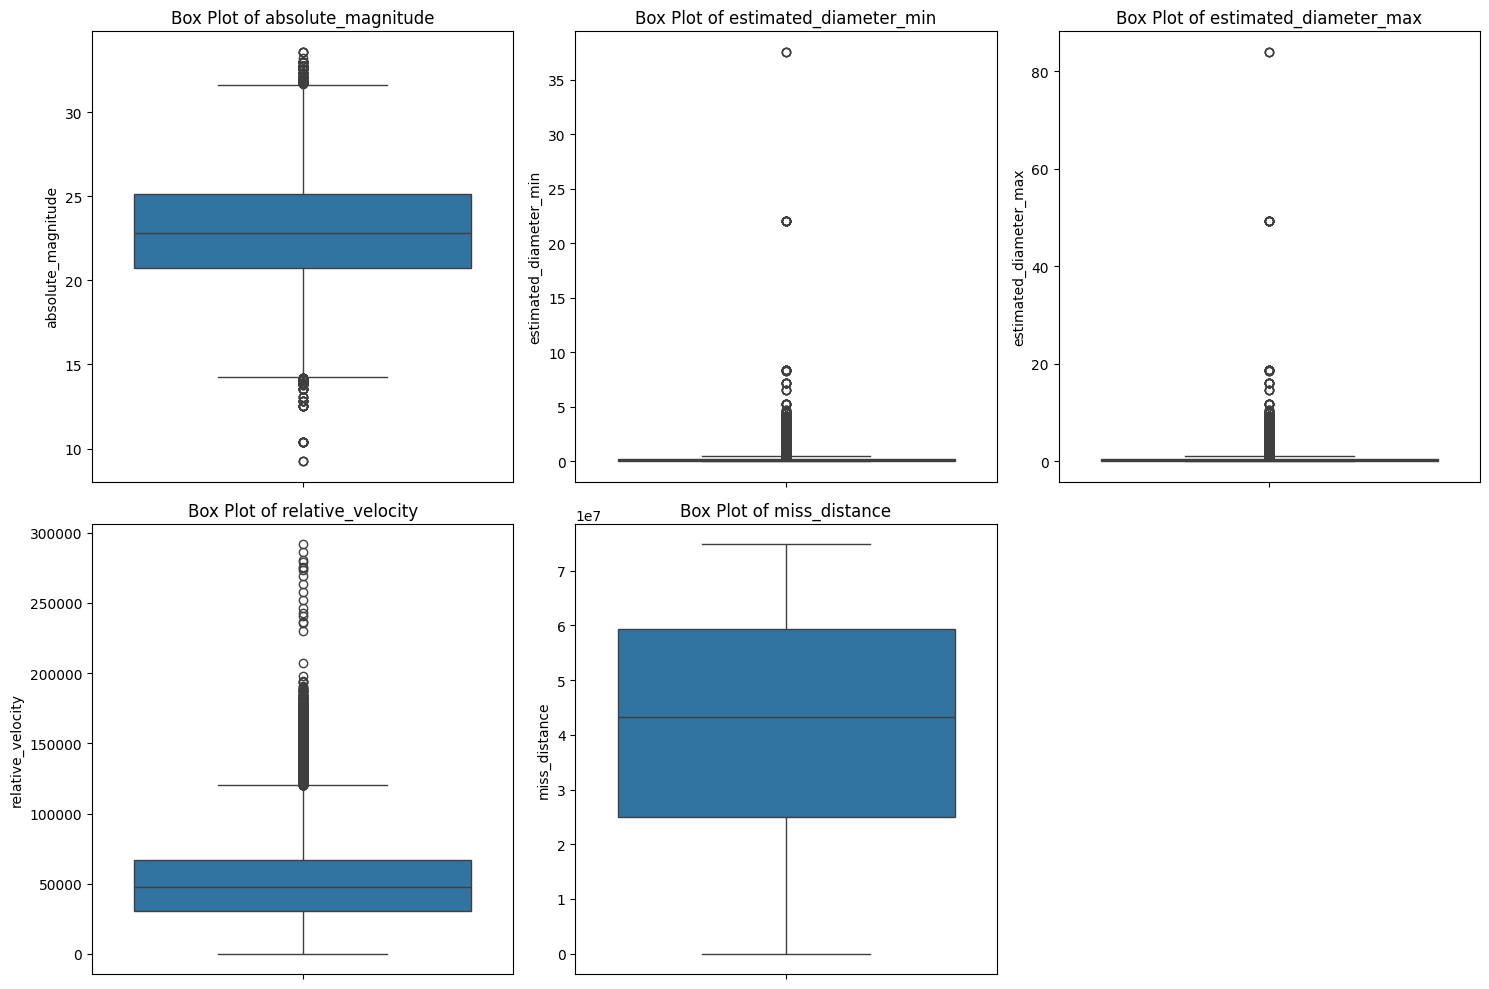

In [ ]:
features_to_visualize = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_visualize, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# Copping Outliers for 'absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity'
columns_to_cap = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity']

for col in columns_to_cap:
    # Calculate IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df[col] = df[col].apply(lambda x: upper_bound if x > upper_bound else x)
    df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else x)

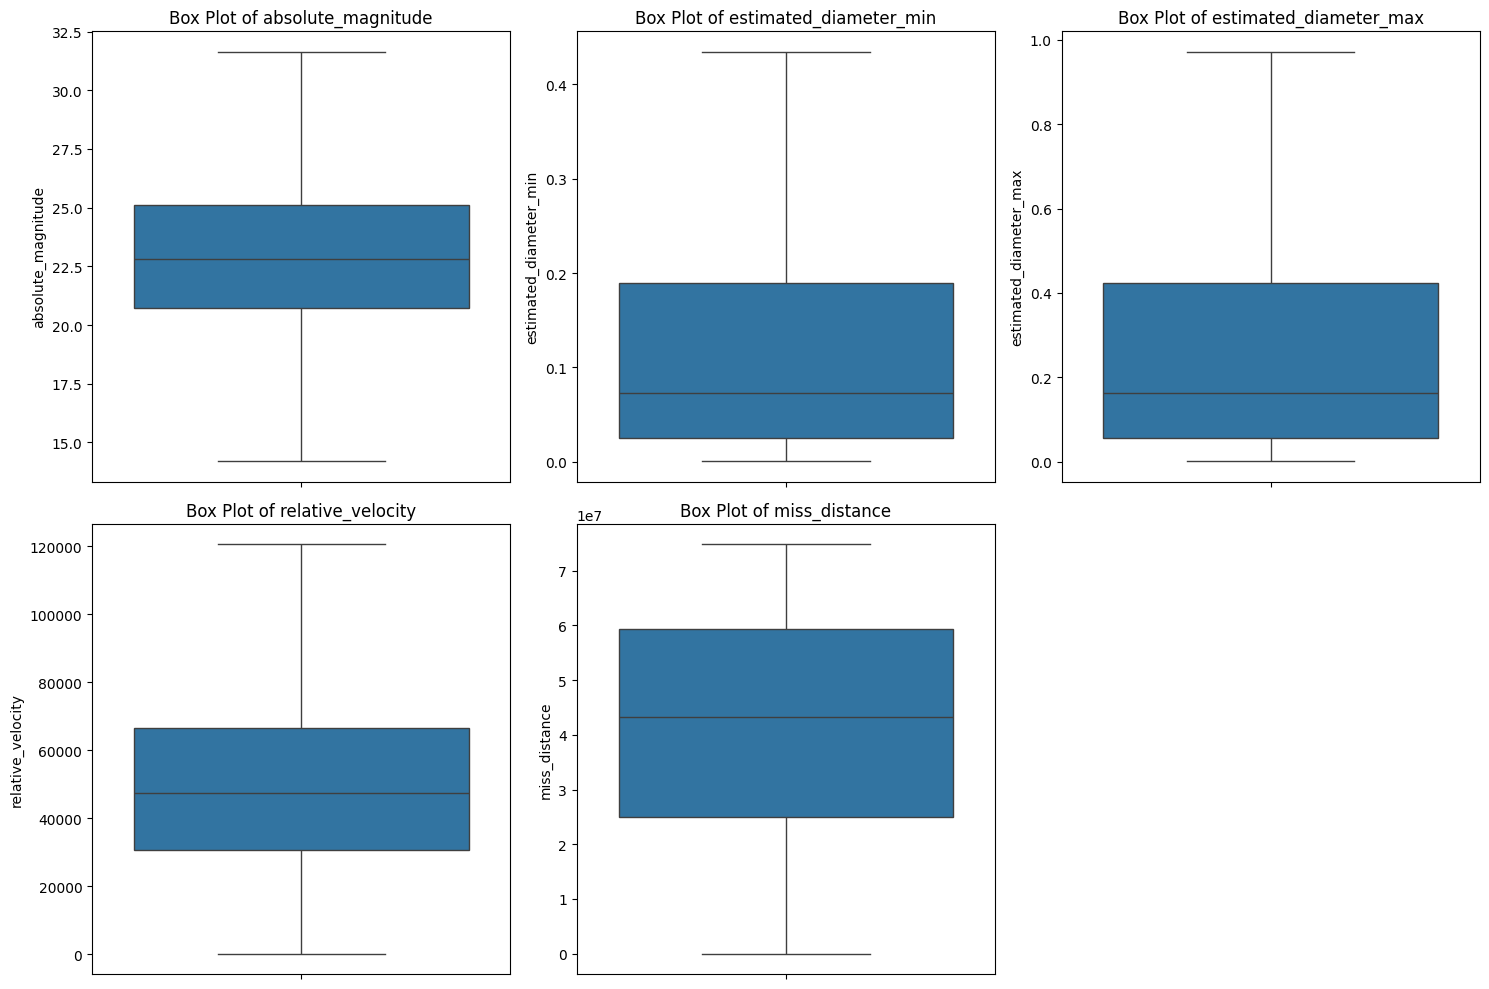

In [ ]:
features_to_visualize = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_visualize, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

# 2. Exploratory Data Analysis (EDA):**bold text**

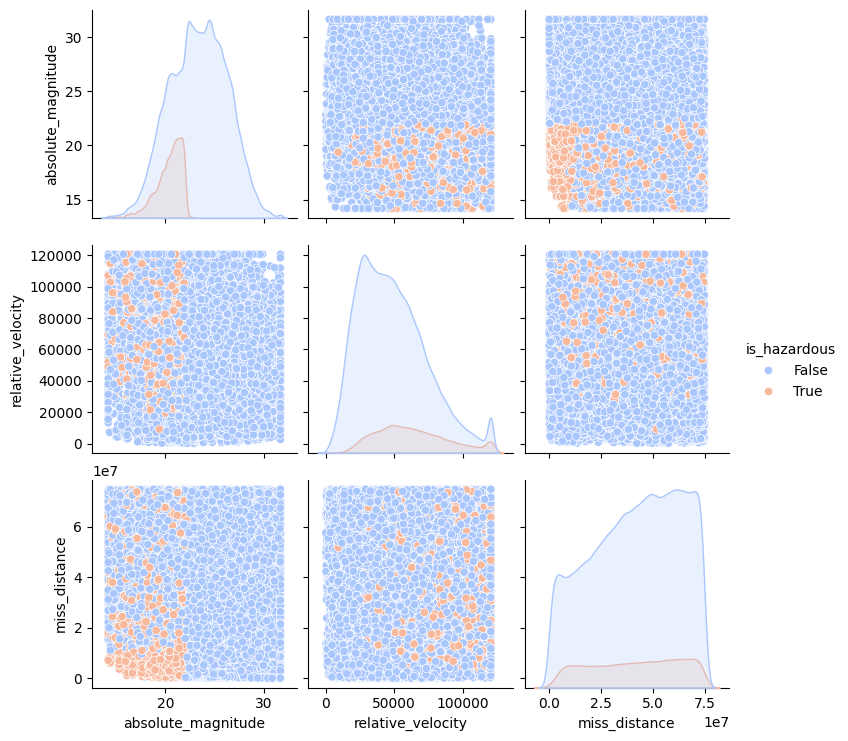

In [ ]:
# Analyze relationships for features.
sns.pairplot(df[['absolute_magnitude', 'relative_velocity', 'miss_distance', 'is_hazardous']], hue='is_hazardous', palette='coolwarm')
plt.show()

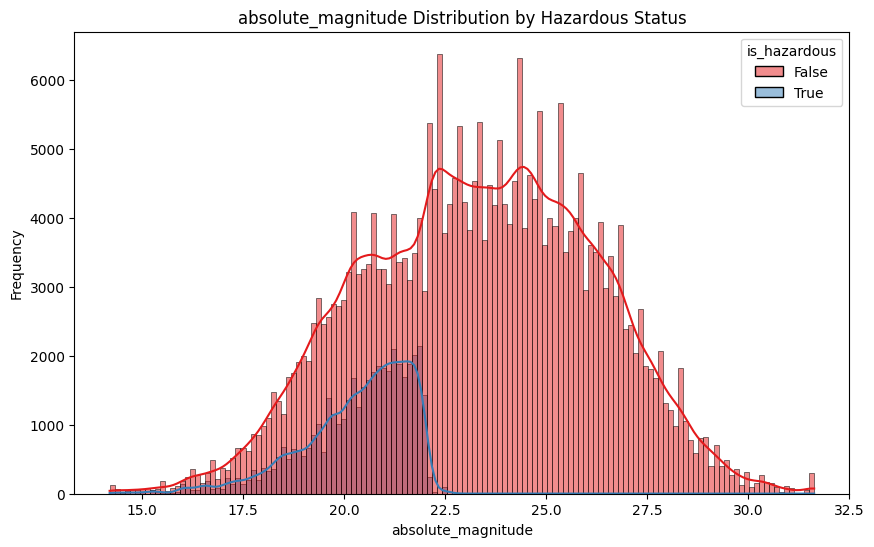

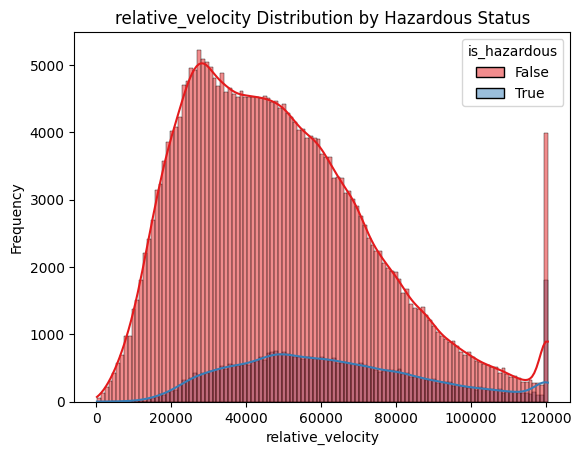

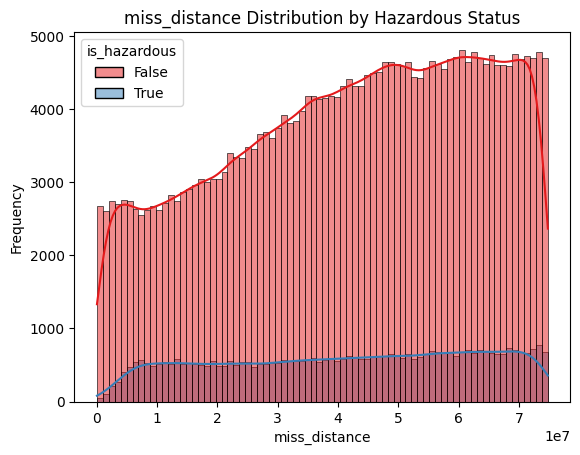

In [ ]:
#Distribution by Hazardous Status
cal = ['absolute_magnitude', 'relative_velocity', 'miss_distance']
plt.figure(figsize=(10, 6))
for c in cal:
  sns.histplot(data=df, x= c, hue='is_hazardous', kde=True, palette='Set1')
  plt.title(c+' Distribution by Hazardous Status')
  plt.xlabel(c)
  plt.ylabel('Frequency')
  plt.show()

# 3. Preprocessing **data**

In [ ]:
# Encode Categorical target
df[df['is_hazardous'].isnull()]

,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous


In [ ]:
# droping
df = df.drop(['name','orbiting_body'], axis=1)

Scaling Features


In [ ]:
df.describe()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,338199.000000,338199.000000,338199.000000,338199.000000,3.381990e+05
mean,22.932376,0.127536,0.285180,50815.913559,4.153535e+07
std,2.908385,0.131728,0.294554,25605.747205,2.077399e+07
min,14.200000,0.000511,0.001143,203.346433,6.745533e+03
25%,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,31.640000,0.434526,0.971629,120616.504330,7.479865e+07


In [ ]:
X = df.drop('is_hazardous', axis=1)
y = df['is_hazardous']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Handling Imbalanced Classes


<ipython-input-20-757fa6b370b3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_hazardous', data=df, palette='coolwarm')


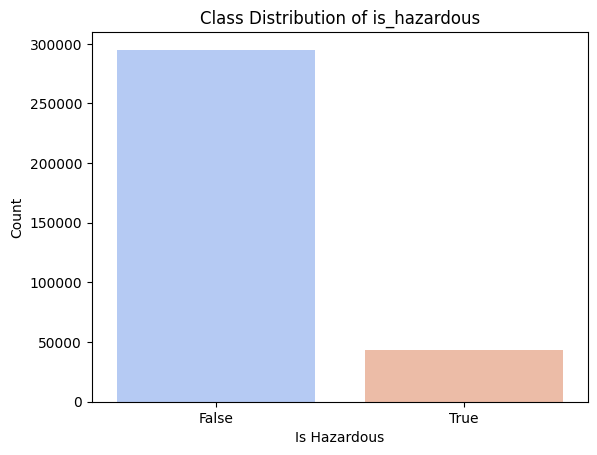

In [ ]:
sns.countplot(x='is_hazardous', data=df, palette='coolwarm')
plt.title('Class Distribution of is_hazardous')
plt.xlabel('Is Hazardous')
plt.ylabel('Count')
plt.show()

In [ ]:
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

In [ ]:
df = np.hstack((X, np.reshape(y,(-1, 1))))
df = pd.DataFrame(df, columns=X.columns.tolist() + ['is_hazardous'])

<ipython-input-23-757fa6b370b3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_hazardous', data=df, palette='coolwarm')


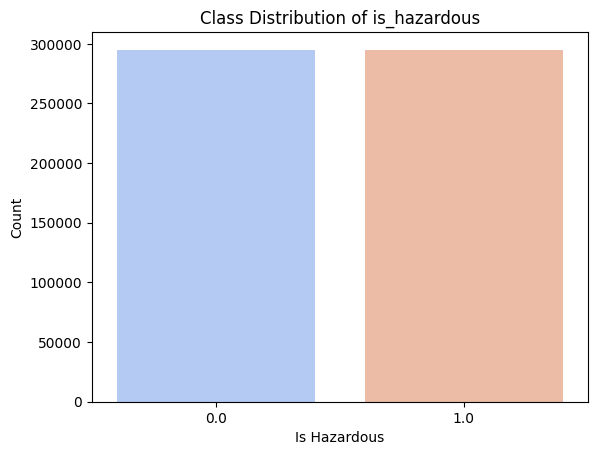

In [ ]:
sns.countplot(x='is_hazardous', data=df, palette='coolwarm')
plt.title('Class Distribution of is_hazardous')
plt.xlabel('Is Hazardous')
plt.ylabel('Count')
plt.show()

In [ ]:
#spliting dataswt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model Training and Evaluation:

The Model:<class 'sklearn.linear_model._logistic.LogisticRegression'>
Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.72      0.67     88580
        True       0.67      0.57      0.62     88443

    accuracy                           0.65    177023
   macro avg       0.65      0.64      0.64    177023
weighted avg       0.65      0.65      0.64    177023

The test accuracy 0.645057421916926
AUC-ROC Score of thr model<class 'sklearn.linear_model._logistic.LogisticRegression'>: 0.72


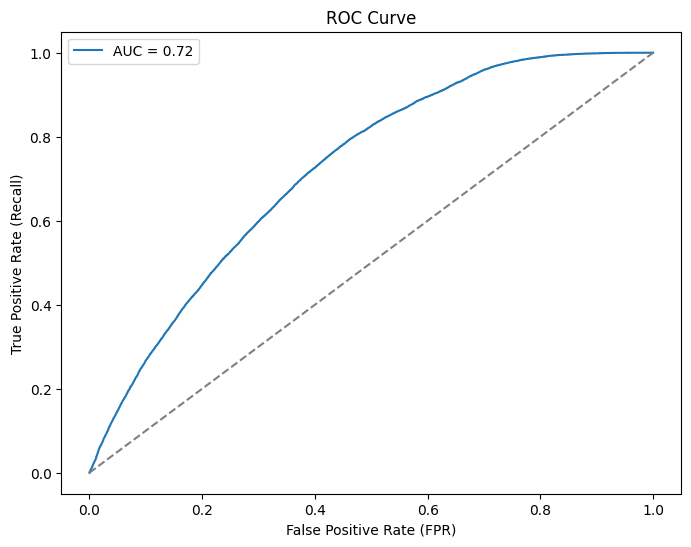

*******************************************************************
The Model:<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.93      0.96     88580
        True       0.93      1.00      0.96     88443

    accuracy                           0.96    177023
   macro avg       0.97      0.96      0.96    177023
weighted avg       0.97      0.96      0.96    177023

The test accuracy 0.9627393050620541
AUC-ROC Score of thr model<class 'sklearn.ensemble._forest.RandomForestClassifier'>: 1.00


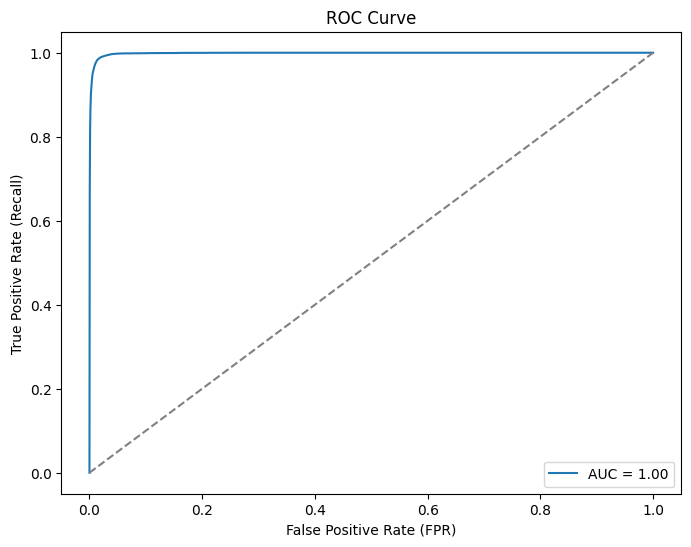

*******************************************************************
The Model:<class 'xgboost.sklearn.XGBClassifier'>
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.74      0.84     88580
        True       0.79      0.98      0.87     88443

    accuracy                           0.86    177023
   macro avg       0.88      0.86      0.86    177023
weighted avg       0.88      0.86      0.86    177023

The test accuracy 0.8594589403636815
AUC-ROC Score of thr model<class 'xgboost.sklearn.XGBClassifier'>: 0.92


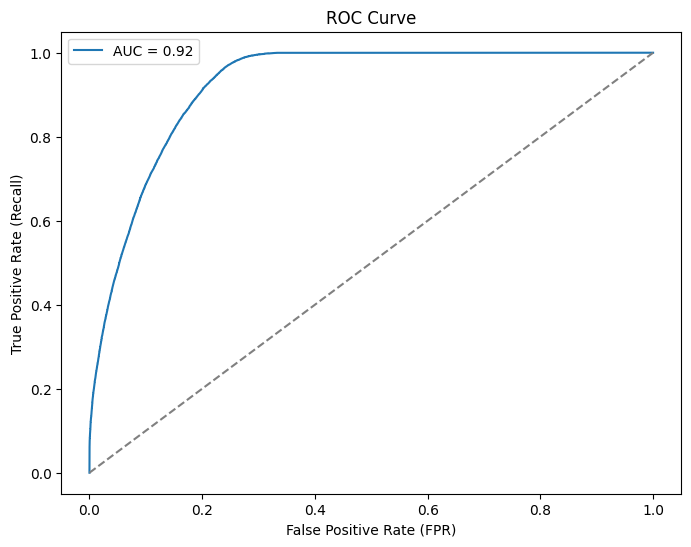

*******************************************************************
The Model:<class 'lightgbm.sklearn.LGBMClassifier'>
[LightGBM] [Info] Number of positive: 206594, number of negative: 206457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1265
[LightGBM] [Info] Number of data points in the train set: 413051, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500166 -> initscore=0.000663
[LightGBM] [Info] Start training from score 0.000663
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.71      0.82     88580
        True       0.77      0.99      0.87     88443

    accuracy                           0.85    177023
   macro avg       0.88      0.85      0.84    177023
weighted avg       0.88      0.85      0.84    177023

The test accuracy 0.8473249238799478

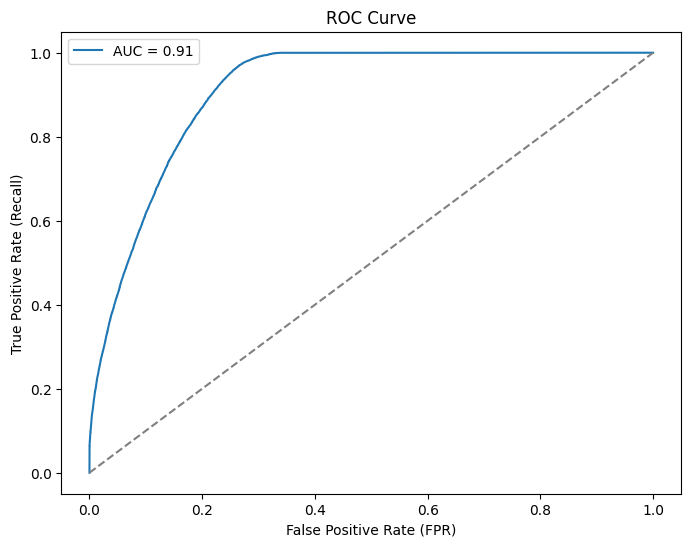

*******************************************************************


In [ ]:
for model_n in [LogisticRegression, RandomForestClassifier,XGBClassifier, LGBMClassifier]:
  print(f"The Model:{model_n}")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  model = model_n(random_state=101)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print("Classification Report:")
  print(classification_report(y_test, y_pred))
  print('The test accuracy',model.score(X_test, y_test))
  # Predict probabilities (for AUC-ROC)
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, y_pred_proba)
  print(f"AUC-ROC Score of thr model{model_n}: {auc:.2f}")
  # Plot ROC Curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (Recall)')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()
  print("*******************************************************************")